# 1. Segmentation d'image

## 1.1 Via l'algorithme des $k$-means

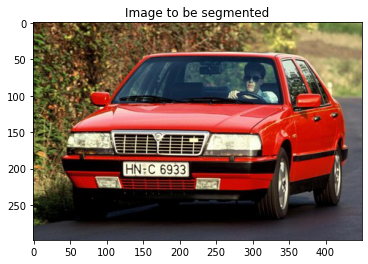

Segmenting picture into 3 clusters using k-means...


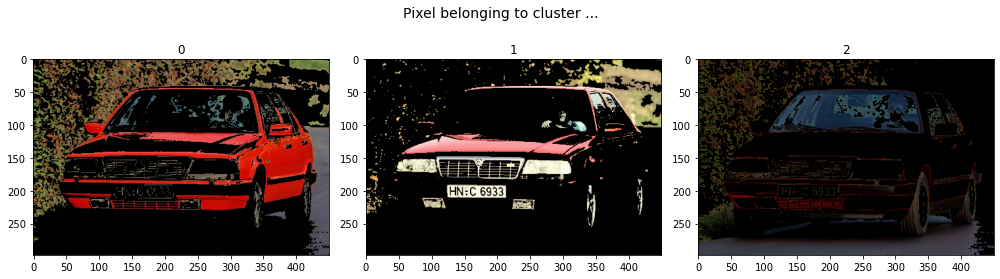

In [57]:
import numpy as np             
import matplotlib.pyplot as plt 

img = plt.imread('data/voiture.jpg')
plt.imshow(img); plt.title("Image to be segmented"); plt.show()

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)  # on impose k=3 pour l'instant, on verra ensuite comment choisir le k optimal ensuite
print("Segmenting picture into 3 clusters using k-means...")
data = img.reshape((img.shape[0]*img.shape[1],3))

labels = kmeans.fit_predict(data)
reshaped_labels = labels.reshape((img.shape[0],img.shape[1]))

fig, ax = plt.subplots(1,3,figsize=(14,4))
fig.suptitle('Pixel belonging to cluster ...',fontsize=14)
for label in range(kmeans.n_clusters):
    mask = (reshaped_labels == label)*1.0 
    ax[label].set_title(str(label))
    ax[label].imshow((img*mask[:,:,np.newaxis]).astype(int),vmin=0,vmax=255)
fig.tight_layout();

## 1.2 Choisir le nombre optimal de clusters pour les $k$-means

On utilise la méthode de l'elbow pour déterminer le meilleur $k$.

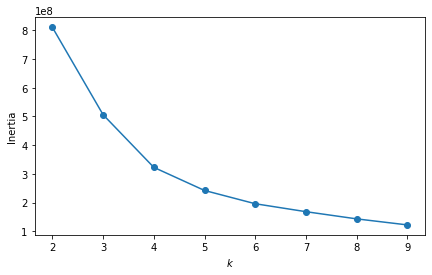

In [81]:
from sklearn.metrics import silhouette_score

k_ranges = np.arange(2,10).astype(int)
SSEs = []
silhouette_scores = []
for k in k_ranges:
    kmeans = KMeans(n_clusters=k)
    label=kmeans.fit_predict(data)
    SSEs.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(data,labels))

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(k_ranges, SSEs); ax.scatter(k_ranges, SSEs);
ax.set_xlabel('$k$'); ax.set_ylabel("Inertia");

- la plus grosse cassure sur la courbe a lieu à $k=4$, c'est donc le $k$ optimal.

Segmenting picture into 4 clusters using k-means...


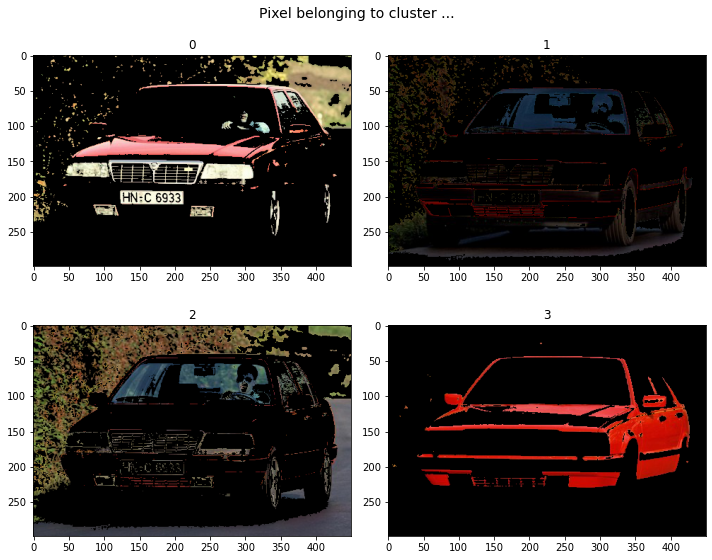

In [89]:
kmeans = KMeans(n_clusters=4)  # on impose k=3 pour l'instant, on verra ensuite comment choisir le k optimal ensuite
print("Segmenting picture into 4 clusters using k-means...")
data = img.reshape((img.shape[0]*img.shape[1],3))

labels = kmeans.fit_predict(data)
reshaped_labels = labels.reshape((img.shape[0],img.shape[1]))

fig, ax = plt.subplots(2,2,figsize=(10,8))
fig.suptitle('Pixel belonging to cluster ...',fontsize=14)
for label in range(kmeans.n_clusters):
    mask = (reshaped_labels == label)*1.0 
    ax.flat[label].set_title(str(label))
    ax.flat[label].imshow((img*mask[:,:,np.newaxis]).astype(int),vmin=0,vmax=255)
fig.tight_layout();

# 2. Compression d'image

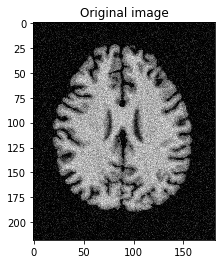

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

im = plt.imread('data/Brain_IRM.jpg').astype(float)
[nb_row, nb_col] = im.shape

plt.imshow(im, plt.cm.gray)
plt.title('Original image');

## 2.1 avec une SVD (Singular Value Decomposition)

(45,) (218, 45) (45, 182)


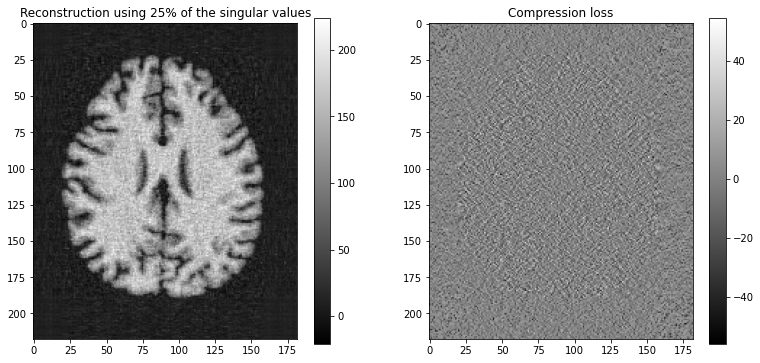

In [94]:
[u,s,vh]=np.linalg.svd(im, full_matrices=False) #Reconstruction based on reduced SVD

keep_frac = 0.25
s2  = s[:int(len(s)*keep_frac)]
u2  = u[:,:int(len(s)*keep_frac)]
vh2 = vh[:int(len(s)*keep_frac)]

print(s2.shape, u2.shape, vh2.shape)

smat2 = np.diag(s2)
im_reconstructed2 = np.dot(u2, np.dot(smat2, vh2))

plt.figure(figsize=(13,6))
plt.subplot(121,title = f'Reconstruction using {keep_frac:.0%} of the singular values')
plt.imshow(im_reconstructed2, plt.cm.gray)
plt.colorbar()

plt.subplot(122,title='Compression loss')
plt.imshow(im_reconstructed2 - im, plt.cm.gray)
plt.colorbar()
plt.show()

- > On voit sur l'image de droite que l'échelle de perte est maintenant de l'ordre de $10^1$, ce qui est évidemment bien plus élevé qu'à la question précédente.
- > On remarque dans l'image reconstruite un niveau de détails moins important, dans les noirs par exemple. Aussi, dans l'image de droite qui semble à première vue n'être que du bruit, on remarque, en faisant attention, la forme du cerveau au sein du bruit. Il y a donc un peu d'information dans cette image.
- > Niveau compresion le rapport est maintenant $\frac{45 + 218*45 + 45 *182}{218*182} = 0.45$, donc on arrive à stocker à peu près la même image sur 55% d'espace en moins

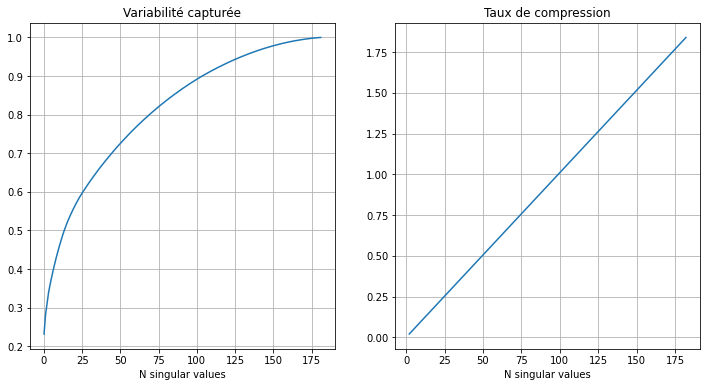

In [96]:
indexs = range(2,182+1)
taux_compressions = []
for index in indexs:
    

    s_  = s[:index]
    u_  = u[:,:index]
    vh_ = vh[:index]
    smat_ = np.diag(s_)
    im_reconstructed_ = np.dot(u_, np.dot(smat_, vh_))
    tc = (s_.shape[0]  + u_.shape[0]*u_.shape[1] + vh_.shape[0]*vh_.shape[1])/(218*182)
    taux_compressions.append(tc)

plt.figure(figsize=(12,6))
plt.subplot(121,title='Variabilité capturée')
plt.xlabel('N singular values')
plt.plot(np.cumsum(np.abs(s))/np.sum(np.abs(s)))
plt.grid();

plt.subplot(122,title='Taux de compression')
plt.plot(indexs,taux_compressions);
plt.xlabel('N singular values')
plt.grid();

On remaraque dans ces graphes que :
- > passées les 100 valeurs singulières, il n'y plus aucun intérêt à la SVD, plus volumineuse que l'image originale
- > que la variabilité capturée est concave, et donc qu'elle crôit de moins en moins fort, ainsi on peut se fixer un seuil et choisir notre nombre de valeurs singulières retenues en fonction comme dans la partie précédente.

## 2.2 avec un filtre passe-bas (Fourier)

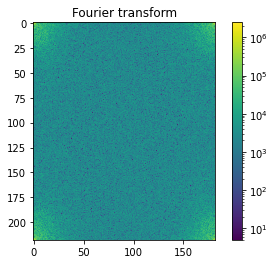

In [97]:
def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))     # A logarithmic colormap
    plt.colorbar()

im_fft = fftpack.fft2(im)

plot_spectrum(im_fft)
plt.title('Fourier transform')
plt.show()



compression rate 53%


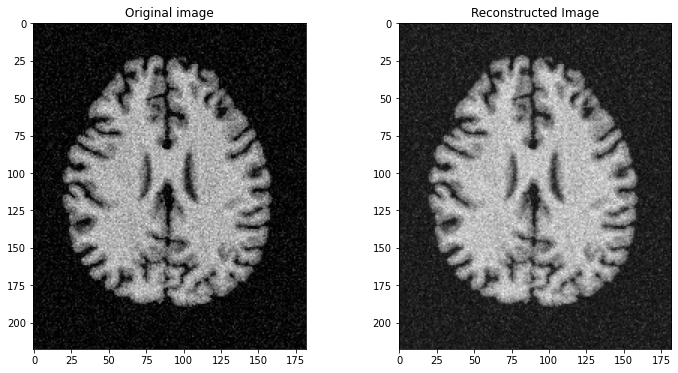

In [104]:
im_fft = fftpack.fft2(im)

compression = 0.53
im_fft2_sparse = (np.abs(im_fft) > np.quantile(np.abs(im_fft),compression))* im_fft   #seuillage

print(f'compression rate {compression:.0%}')
im_compressed = fftpack.ifft2(im_fft2_sparse).real    #restitution

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(im, plt.cm.gray)
plt.title('Original image')
plt.subplot(122)
plt.imshow(im_compressed, plt.cm.gray)
plt.title('Reconstructed Image')

plt.show()